In [3]:
!pip install pennylane torch numpy scikit-learn
!pip install pennylane-lightning[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 71.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
import pennylane as qml
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import urllib.request
import tarfile
import os
import random

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Configurations
n_qubits = 8
q_depth = 3
batch_size = 16
num_epochs = 10
learning_rate = 5e-5
num_repeats = 5  # Число повторов

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Quantum circuit & Quantum Layer ===
qml_dev = qml.device("lightning.gpu", wires=n_qubits)

@qml.qnode(qml_dev, interface='torch', diff_method="adjoint")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (q_depth, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.norm = nn.BatchNorm1d(n_qubits)
    def forward(self, x):
        x = nn.functional.normalize(x)
        x = self.qlayer(x)
        return self.norm(x)

class QuantumBERT(nn.Module):
    def __init__(self, bert_model="bert-base-uncased"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.3)
        self.quantum_layer = QuantumLayer()
        self.fc = nn.Linear(n_qubits, 2)
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask).pooler_output
        bert_output = self.dropout(bert_output[:, :n_qubits])
        quantum_output = self.quantum_layer(bert_output)
        return self.fc(quantum_output)

# --- Prepare Data (load only once!) ---
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
filename = 'aclImdb_v1.tar.gz'
if not os.path.exists('aclImdb'):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
train_data = load_files('aclImdb/train', categories=['pos', 'neg'], encoding='utf-8')

# --- Метрики ---
accuracies, precisions, recalls, f1s = [], [], [], []
train_losses_all, val_losses_all = [], []

def print_mean_std(name, arr):
    print(f"{name}: mean = {np.mean(arr):.4f}, std = {np.std(arr):.4f}")

for repeat in range(num_repeats):
    print(f"\n=== Repeat {repeat + 1}/{num_repeats} ===")
    # --- Случайная выборка 2000 ---
    indices = np.random.choice(len(train_data.data), 2000, replace=False)
    texts = [train_data.data[i] for i in indices]
    labels = [train_data.target[i] for i in indices]
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.2, random_state=random.randint(0, 10000)
    )

    # Токенизация
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    train_labels = torch.tensor(train_labels)
    val_labels = torch.tensor(val_labels)

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Model, Optimizer, Loss
    model = QuantumBERT().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # --- Train ---
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}")
    train_losses_all.append(avg_loss)

    # --- Evaluation ---
    model.eval()
    preds, truths = [], []
    val_losses = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            truths.extend(labels.cpu().numpy())

    val_loss_mean = np.mean(val_losses)
    val_losses_all.append(val_loss_mean)

    accuracy = accuracy_score(truths, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(truths, preds, average='binary')
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print(f'Val Loss: {val_loss_mean:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# --- Выводим итоговые метрики ---
print("\n==== Statistics over runs ====")
print_mean_std('Train Loss', train_losses_all)
print_mean_std('Val Loss', val_losses_all)
print_mean_std('Accuracy', accuracies)
print_mean_std('Precision', precisions)
print_mean_std('Recall', recalls)
print_mean_std('F1-score', f1s)



=== Repeat 1/5 ===
Epoch 1/10, Train Loss: 0.7652
Epoch 2/10, Train Loss: 0.7569
Epoch 3/10, Train Loss: 0.7590
Epoch 4/10, Train Loss: 0.7304
Epoch 5/10, Train Loss: 0.7503
Epoch 6/10, Train Loss: 0.7520
Epoch 7/10, Train Loss: 0.7536
Epoch 8/10, Train Loss: 0.7376
Epoch 9/10, Train Loss: 0.7305
Epoch 10/10, Train Loss: 0.7424
Val Loss: 0.7485, Accuracy: 0.4925, Precision: 0.4925, Recall: 1.0000, F1-score: 0.6600

=== Repeat 2/5 ===
Epoch 1/10, Train Loss: 0.7142
Epoch 2/10, Train Loss: 0.6911
Epoch 3/10, Train Loss: 0.5770
Epoch 4/10, Train Loss: 0.4559
Epoch 5/10, Train Loss: 0.4214
Epoch 6/10, Train Loss: 0.3791
Epoch 7/10, Train Loss: 0.3449
Epoch 8/10, Train Loss: 0.3387
Epoch 9/10, Train Loss: 0.2981
Epoch 10/10, Train Loss: 0.3068
Val Loss: 0.4351, Accuracy: 0.8275, Precision: 0.7983, Recall: 0.9005, F1-score: 0.8463

=== Repeat 3/5 ===
Epoch 1/10, Train Loss: 0.6609
Epoch 2/10, Train Loss: 0.4344
Epoch 3/10, Train Loss: 0.3148
Epoch 4/10, Train Loss: 0.2581
Epoch 5/10, Train 

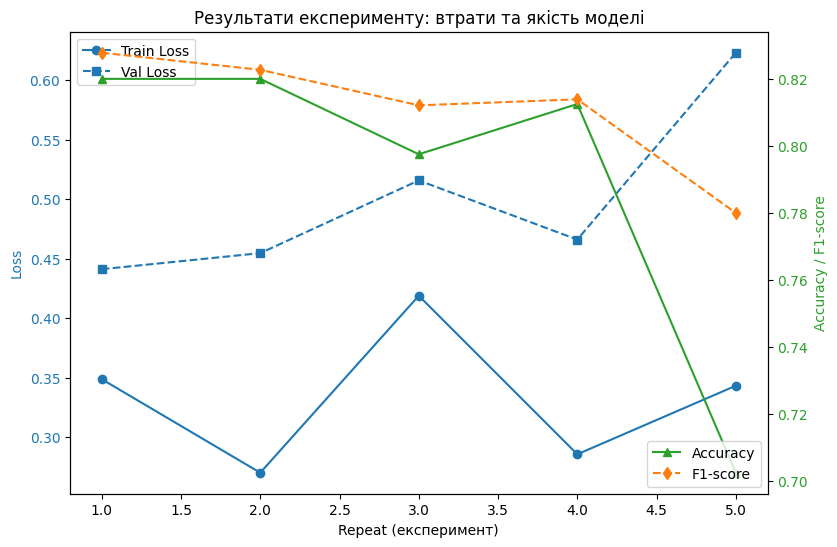

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Значення взяті з результатів на зображенні
train_losses = [0.3487, 0.2701, 0.4188, 0.2856, 0.3432]
val_losses = [0.4411, 0.4546, 0.5157, 0.4660, 0.6230]
accuracies = [0.8200, 0.8200, 0.7975, 0.8125, 0.7025]
f1_scores = [0.8278, 0.8227, 0.8121, 0.8139, 0.7800]

x = np.arange(1, 6)

fig, ax1 = plt.subplots(figsize=(9, 6))

# Втрати (Loss)
ax1.set_xlabel('Repeat (експеримент)')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(x, train_losses, marker='o', label='Train Loss', color='tab:blue', linestyle='-')
ax1.plot(x, val_losses, marker='s', label='Val Loss', color='tab:blue', linestyle='--')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Якість (Accuracy, F1)
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy / F1-score', color='tab:green')
ax2.plot(x, accuracies, marker='^', label='Accuracy', color='tab:green', linestyle='-')
ax2.plot(x, f1_scores, marker='d', label='F1-score', color='tab:orange', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='lower right')

plt.title('Результати експерименту: втрати та якість моделі')
plt.show()

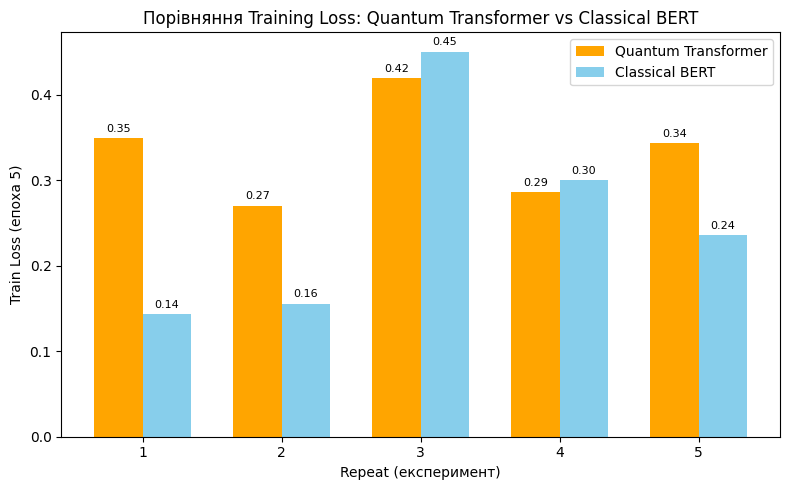

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Training Loss (TrainLoss) із результатів скріншотів
# Quantum Transformer (середні Train Loss по 5 експериментах, епоха 5)
quantum_train_losses = [0.3487, 0.2701, 0.4188, 0.2856, 0.3432]

# Classical BERT (середні Train Loss по 5 експериментах, епоха 5)
classical_train_losses = [0.1438, 0.1556, 0.4502, 0.2997, 0.2357]

x = np.arange(1, 6)  # Номери експериментів
width = 0.35  # ширина стовпчика

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, quantum_train_losses, width, label='Quantum Transformer', color='orange')
rects2 = ax.bar(x + width/2, classical_train_losses, width, label='Classical BERT', color='skyblue')

ax.set_xlabel('Repeat (експеримент)')
ax.set_ylabel('Train Loss (епоха 5)')
ax.set_title('Порівняння Training Loss: Quantum Transformer vs Classical BERT')
ax.set_xticks(x)
ax.legend()

# Додавання підписів на стовпчиках
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


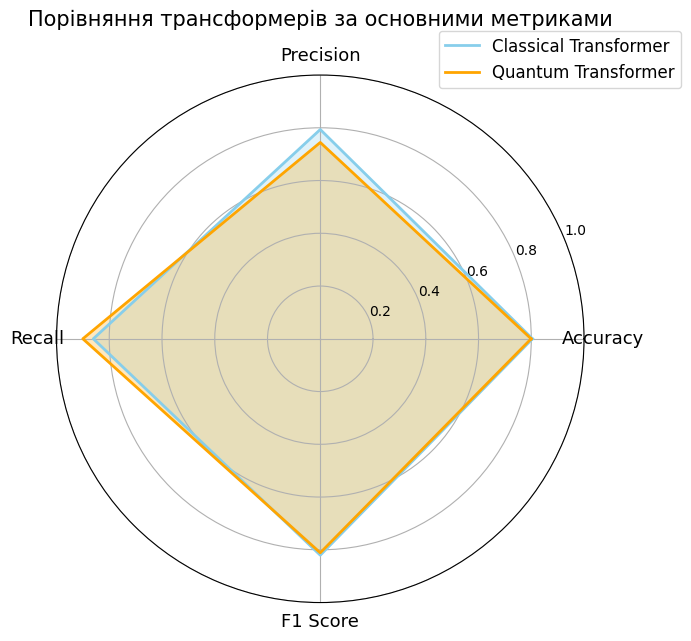

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Початкові унікальні мітки
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Метрики без повторення (4 значення)
classical_metrics = [0.8045, 0.7935, 0.8605, 0.8205]
quantum_metrics = [0.7995, 0.7444, 0.9002, 0.8113]

# Додаємо перший елемент у кінець для замикання кола
classical_metrics.append(classical_metrics[0])
quantum_metrics.append(quantum_metrics[0])

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # також додаємо перший кут для замикання кола

fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

ax.plot(angles, classical_metrics, color='skyblue', linewidth=2, label='Classical Transformer')
ax.fill(angles, classical_metrics, color='skyblue', alpha=0.25)

ax.plot(angles, quantum_metrics, color='orange', linewidth=2, label='Quantum Transformer')
ax.fill(angles, quantum_metrics, color='orange', alpha=0.25)

# ВАЖЛИВО: встановлюємо унікальні мітки (без повторення!)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=13)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2','0.4','0.6','0.8','1.0'])
ax.set_title('Порівняння трансформерів за основними метриками', fontsize=15, pad=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=12)

plt.tight_layout()
plt.show()


